## Convolutional Neural Networks

In [1]:
!pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

### Dense MNIST Classifier

In [23]:
batch_size = 32

data_train = torchvision.datasets.MNIST('./data',
        download=True,train=True,transform=ToTensor())
data_test = torchvision.datasets.MNIST('./data',
        download=True,train=False,transform=ToTensor())
train_loader = torch.utils.data.DataLoader(data_train,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(data_test,batch_size=batch_size)


In [21]:
for x,y in train_loader:
  print(x.size(),y.size())
  break

torch.Size([1, 1, 28, 28]) torch.Size([1])


In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(f'Using device={device}')

def validate(net,test_loader):
  count=acc=0
  for xo,yo in test_loader:
    x,y = xo.to(device), yo.to(device)
    with torch.no_grad():
      p = net.forward(x)
      _,predicted = torch.max(p,1)
      acc+=(predicted==y).sum()
      count+=len(x)
  return acc/count

def train(net,train_loader,test_loader,epochs=3,loss_fn=torch.nn.CrossEntropyLoss()):
  net = net.to(device)
  optimizer = torch.optim.Adam(net.parameters())
  for ep in range(epochs):
    count=acc=0
    for xo,yo in train_loader:
      x = xo.to(device)
      y = yo.to(device)
      optimizer.zero_grad()
      p = net.forward(x)
      loss = loss_fn(p,y)
      loss.backward()
      optimizer.step()
      _,predicted = torch.max(p,1)
      acc+=(predicted==y).sum()
      count+=len(x)
    val_acc = validate(net,test_loader)
    print(f"Epoch={ep}, train_acc={acc/count}, val_acc={val_acc}")

net = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,10),
    torch.nn.Softmax(dim=-1)
    )

summary(net)

train(net,train_loader,test_loader,epochs=3)

Using device=cuda
Layer (type:depth-idx)                   Param #
├─Flatten: 1-1                           --
├─Linear: 1-2                            78,500
├─ReLU: 1-3                              --
├─Linear: 1-4                            1,010
├─Softmax: 1-5                           --
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0


KeyboardInterrupt: ignored

## Convolutions

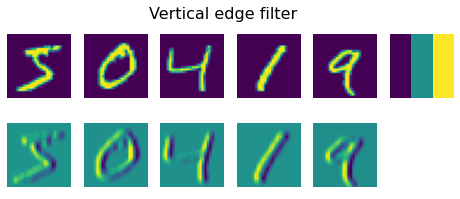

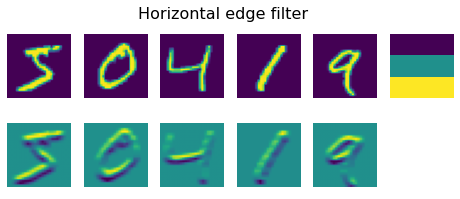

In [11]:
def plot_convolution(t,title=''):
    with torch.no_grad():
        c = nn.Conv2d(kernel_size=(3,3),out_channels=1,in_channels=1)
        c.weight.copy_(t)
        fig, ax = plt.subplots(2,6,figsize=(8,3))
        fig.suptitle(title,fontsize=16)
        for i in range(5):
            im = data_train[i][0]
            ax[0][i].imshow(im[0])
            ax[1][i].imshow(c(im.unsqueeze(0))[0][0])
            ax[0][i].axis('off')
            ax[1][i].axis('off')
        ax[0,5].imshow(t)
        ax[0,5].axis('off')
        ax[1,5].axis('off')
        #plt.tight_layout()
        plt.show()

plot_convolution(torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),'Vertical edge filter')
plot_convolution(torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),'Horizontal edge filter')


In [12]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1,out_channels=10,kernel_size=(5,5)),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(24*24*10,10),
    torch.nn.Softmax(dim=-1)
)

train(net,train_loader,test_loader)

summary(net)

Epoch=0, train_acc=0.9200833439826965, val_acc=0.9593999981880188
Epoch=1, train_acc=0.9629833698272705, val_acc=0.9685999751091003
Epoch=2, train_acc=0.9718166589736938, val_acc=0.972000002861023
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            260
├─ReLU: 1-2                              --
├─Flatten: 1-3                           --
├─Linear: 1-4                            57,610
├─Softmax: 1-5                           --
Total params: 57,870
Trainable params: 57,870
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            260
├─ReLU: 1-2                              --
├─Flatten: 1-3                           --
├─Linear: 1-4                            57,610
├─Softmax: 1-5                           --
Total params: 57,870
Trainable params: 57,870
Non-trainable params: 0

In [24]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(5184,10)

    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = OneConv()

summary(net,input_size=(1,1,28,28))

train(net,train_loader,test_loader)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            234
├─Flatten: 1-2                           --
├─Linear: 1-3                            51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
Epoch=0, train_acc=0.9361500144004822, val_acc=0.9675999879837036
Epoch=1, train_acc=0.9750500321388245, val_acc=0.9746999740600586
Epoch=2, train_acc=0.9817166924476624, val_acc=0.9789999723434448


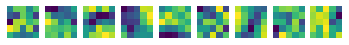

In [25]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

In [28]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1,out_channels=10,kernel_size=(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2,2),
    torch.nn.Conv2d(in_channels=10,out_channels=20,kernel_size=(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2,2),
    torch.nn.Flatten(),
    torch.nn.Linear(320,10),
    torch.nn.Softmax(dim=-1)
)

train(net,train_loader,test_loader)

summary(net)

Epoch=0, train_acc=0.8604166507720947, val_acc=0.9623000025749207
Epoch=1, train_acc=0.9707500338554382, val_acc=0.973800003528595
Epoch=2, train_acc=0.9771333336830139, val_acc=0.981499969959259
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            260
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            5,020
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Flatten: 1-7                           --
├─Linear: 1-8                            3,210
├─Softmax: 1-9                           --
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            260
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            5,020
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Flatten: 1-7                           --
├─Linear: 1-8                            3,210
├─Softmax: 1-9                           --
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0

## CIFAR-10

In [29]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=14, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


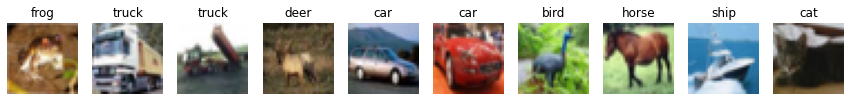

In [30]:
def display_dataset(dataset, n=10,classes=None):
    fig,ax = plt.subplots(1,n,figsize=(15,3))
    mn = min([dataset[i][0].min() for i in range(n)])
    mx = max([dataset[i][0].max() for i in range(n)])
    for i in range(n):
        ax[i].imshow(np.transpose((dataset[i][0]-mn)/(mx-mn),(1,2,0)))
        ax[i].axis('off')
        if classes:
            ax[i].set_title(classes[dataset[i][1]])

display_dataset(trainset,classes=classes)

In [31]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,120,5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120,64)
        self.fc2 = nn.Linear(64,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = LeNet()

summary(net,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            456
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            2,416
├─Conv2d: 1-4                            48,120
├─Flatten: 1-5                           --
├─Linear: 1-6                            7,744
├─Linear: 1-7                            650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            456
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            2,416
├─Conv2d: 1-4                            48,120
├─Flatten: 1-5                           --
├─Linear: 1-6                            7,744
├─Linear: 1-7                            650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0

In [32]:
train(net, trainloader, testloader)

Epoch=0, train_acc=0.439300000667572, val_acc=0.5119999647140503
Epoch=1, train_acc=0.5458399653434753, val_acc=0.5670999884605408
Epoch=2, train_acc=0.5903599858283997, val_acc=0.5823000073432922


In [33]:
train(net, trainloader, testloader)

Epoch=0, train_acc=0.6213799715042114, val_acc=0.5985000133514404
Epoch=1, train_acc=0.6396999955177307, val_acc=0.600600004196167
Epoch=2, train_acc=0.6564599871635437, val_acc=0.6232999563217163


In [34]:
train(net, trainloader, testloader,epochs=7)

Epoch=0, train_acc=0.6710799932479858, val_acc=0.6177999973297119
Epoch=1, train_acc=0.6815800070762634, val_acc=0.6179999709129333
Epoch=2, train_acc=0.6930399537086487, val_acc=0.6272000074386597
Epoch=3, train_acc=0.70278000831604, val_acc=0.6168000102043152
Epoch=4, train_acc=0.7127599716186523, val_acc=0.623699963092804
Epoch=5, train_acc=0.7197799682617188, val_acc=0.6214999556541443
Epoch=6, train_acc=0.7278199791908264, val_acc=0.6259999871253967


In [35]:
train(net, trainloader, testloader,epochs=7)

Epoch=0, train_acc=0.731660008430481, val_acc=0.6283000111579895
Epoch=1, train_acc=0.7396999597549438, val_acc=0.6262999773025513
Epoch=2, train_acc=0.7447199821472168, val_acc=0.6261000037193298
Epoch=3, train_acc=0.751259982585907, val_acc=0.626800000667572
Epoch=4, train_acc=0.7574999928474426, val_acc=0.6139000058174133
Epoch=5, train_acc=0.7604799866676331, val_acc=0.6261999607086182
Epoch=6, train_acc=0.763439953327179, val_acc=0.6281999945640564
